# Imports

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import timedelta
from connection_keys import connection
import statsmodels.api as sm

import warnings
import itertools
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

pd.set_option('display.max_colwidth', None)

from utils import transforma_campo_str_int

### Conexão com o banco e captura os dados

In [35]:
connectionbd = connection('db_hardware')
query = """
    select * from graphic_card
"""
df = pd.read_sql(query, connectionbd)

### Apresentação de uma amostra dos dados e dos tipo em que estão vindo

In [31]:
print('Tipo dos campso')
display(df.dtypes)
print('Amostra')
display(df.sample(5))

Tipo dos campso


id                      int64
marca                  object
nome_produto           object
preco_antigo_cartao    object
preco_atual_cartao     object
preco_boleto           object
data                   object
hora                   object
loja                   object
disponibilidade        object
dtype: object

Amostra


,id,marca,nome_produto,preco_antigo_cartao,preco_atual_cartao,preco_boleto,data,hora,loja,disponibilidade
35738,40893,Zotac,"Placa de Vídeo Zotac NVIDIA GeForce RTX 2070 Super Mini, 8GB, GDDR6 - ZT-T20710E-10M",0,"4.023,41","3.419,90",2020-12-11,20:56:28,Kabum,Indisponivel
34832,39987,Afox,"Placa de Vídeo Afox AMD Radeon RX560D, 4GB, GDDR5 - AFRX560D-4096D5H4-V3",0,"823,41","699,90",2020-12-09,18:09:18,Kabum,Indisponivel
13818,15574,Gigabyte,"Placa de Vídeo Gigabyte NVIDIA GeForce GTX 1650 D6 OC Low Profile 4G, 4GB, GDDR6 - GV-N1656OC-4GL","1.799,16","1.529,29","1.299,90",2020-10-22,18:17:43,Kabum,Disponivel
18657,21571,Gainward,"Placa de Vídeo Gainward NVIDIA GeForce RTX 2080 TI Phoenix, 11GB, GDDR6 - NE6208TT20LC-150X","12.623,41","5.882,24","4.999,90",2020-11-04,17:23:54,Kabum,Indisponivel
6563,6564,Zotac,"Placa de Vídeo Zotac NVIDIA GeForce GT 710 1GB, DDR3 - ZT-71304-20L","381,06","352,82","299,90",2020-09-29,22:07:25,Kabum,Disponivel


### Modelagem dos campos para a analise

In [4]:
# df.apply(lambda x: concatena_numero_apolice_seguradora(x['insurerCode'], x['insurerPolicyNumber']),axis=1)
df['preco_antigo_cartao'] = df['preco_antigo_cartao'].str.replace('.', '').str.replace(',', '.').astype(float)
df['preco_atual_cartao'] = df['preco_atual_cartao'].str.replace('.', '').str.replace(',', '.').astype(float)
df['preco_boleto'] = df['preco_boleto'].str.replace('.', '').str.replace(',', '.').astype(float)
df['nome_produto'] = df['nome_produto'].str.upper()
df['marca'] = df['marca'].str.upper()
df['data_hora'] = pd.to_datetime(df['data'] + ' ' + df['hora'])
df['data'] = pd.to_datetime(df['data'])

#### Primeiro método para checar ruidos nos dados, a intenção é pegar oq não se enquadra como  placa de video

In [5]:
def get_resume_product_name(name):
    # string = df['nome_produto'][df['id'] == 259].item()
    pattern = "(RTX|GTX|GT|RX|WX|Quadro|R7|R5|R9|HD)(\d+)"
    resume_name = re.search(pattern, name.replace(" ", ""))
    if resume_name is None: 
        return '' 
    else: 
        return resume_name.group()

df['nome_produto_resumido'] = df.apply(lambda x: get_resume_product_name(x['nome_produto']), axis=1)

In [6]:
display(len(df.query('nome_produto_resumido == ""')))
df.query('nome_produto_resumido == ""')

2652

,id,marca,nome_produto,preco_antigo_cartao,preco_atual_cartao,preco_boleto,data,hora,loja,disponibilidade,data_hora,nome_produto_resumido
7,8,RISE MODE,SUPORTE PARA PLACA DE VÍDEO VGA RISE ATÉ 2 PLACAS RM-SV-01-BK,31.47,27.26,25.9,2020-09-10,19:12:39,Kabum,Disponivel,2020-09-10 19:12:39,
20,21,RISE MODE,SUPORTE PARA PLACA DE VÍDEO VGA RISE TRANSPARENTE RM-SV-01-AQ,39.89,28.78,25.9,2020-09-10,19:12:39,Kabum,Disponivel,2020-09-10 19:12:39,
28,29,RISE MODE,SUPORTE PARA PLACA DE VÍDEO RISE LV2 SMALL BLACK AND WHITE RM-SV-04-BW,54.00,44.59,37.9,2020-09-10,19:12:39,Kabum,Disponivel,2020-09-10 19:12:39,
37,38,RISE MODE,SUPORTE PARA PLACA DE VÍDEO VGA RISE ATÉ 2 PLACAS RM-SV-01-BK,31.47,27.26,25.9,2020-09-10,19:12:39,Kabum,Disponivel,2020-09-10 19:12:39,
50,51,RISE MODE,SUPORTE PARA PLACA DE VÍDEO VGA RISE TRANSPARENTE RM-SV-01-AQ,39.89,28.78,25.9,2020-09-10,19:12:39,Kabum,Disponivel,2020-09-10 19:12:39,
...,...,...,...,...,...,...,...,...,...,...,...,...
37511,42666,SAPPHIRE,"PLACA DE VÍDEO SAPPHIRE AMD RADEON GPRO 6200 4GB, GDDR5 - 32258-00-21G",0.00,1732.82,1472.9,2020-12-15,20:23:36,Kabum,Indisponivel,2020-12-15 20:23:36,
37581,42736,DEEPCOOL,SUPORTE PARA PLACA DE VÍDEO DEEPCOOL - GH-01 A-RGB,0.00,117.53,99.9,2020-12-15,20:23:36,Kabum,Indisponivel,2020-12-15 20:23:36,
37628,42783,PNY,"PLACA DE VÍDEO PNY NVIDIA QUADRO P1000, 4GB, GDDR5 - VCQP1000V2-PB",3623.91,3529.29,2999.9,2020-12-15,20:23:36,Kabum,Indisponivel,2020-12-15 20:23:36,
37667,42822,DEEPCOOL,SUPORTE PARA PLACA DE VÍDEO VGA DEEPCOOL - GH-01 RGB,0.00,70.47,59.9,2020-12-15,20:23:36,Kabum,Indisponivel,2020-12-15 20:23:36,


#### Drop dos dados que foram pegos na limpeza dos dados como não sendo placas de videos para analise

In [7]:
indexNames = df.query('nome_produto.str.contains("SUPORTE") | nome_produto.str.contains("CASE")').index
df.drop(indexNames , inplace=True)
del df['nome_produto_resumido']

# Analise

#### Verificando qual marca de placa de video tem em média o maior preço

In [8]:
df_marcas = df['preco_atual_cartao'].groupby(df['marca']).mean().sort_values(ascending=False)
print(df_marcas)

marca
AORUS         6833.004714
GAINWARD      5766.658036
AMD           5531.318158
COLORFUL      4905.248972
ASUS          3865.514161
PNY           3762.594451
EVGA          3761.215794
MSI           2994.356553
GALAX         2982.873531
ZOTAC         2719.528968
GIGABYTE      2651.154534
ASROCK        2425.292015
SAPPHIRE      2193.882463
XFX           2048.621177
POWERCOLOR    1765.954155
HUSKY          821.538636
PCYES          672.316065
AFOX           423.359265
ADATA          242.644783
Name: preco_atual_cartao, dtype: float64


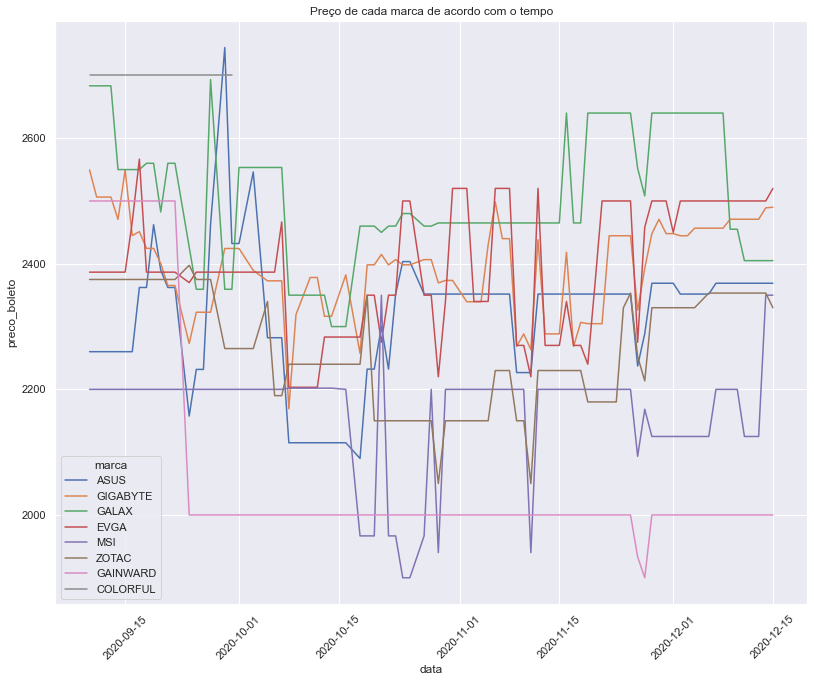

In [9]:
placa = 'RTX 2060'
analise = df.query(f'nome_produto.str.contains("{placa}") & (~nome_produto.str.contains("TI") & ~nome_produto.str.contains("SUPER"))')
# (analise['preco_atual_cartao'].groupby(analise['marca']).mean())
sns.set(rc={'figure.figsize':(12,10)})
plt.xticks(rotation = 45)
ax = sns.lineplot(
    x="data",
    y="preco_boleto",
    hue='marca',
    data=analise,
    ci=None,
    markers=True
).set_title('Preço de cada marca de acordo com o tempo');

In [10]:
# placa = 'RTX 2070 SUPER'
# analise = df.query(f'nome_produto.str.contains("{placa}")')
# plt.xticks(rotation = 45)
# # (analise['preco_atual_cartao'].groupby(analise['marca']).mean())
# sns.set(rc={'figure.figsize':(12,10)})
# ax = sns.lineplot(
#     x="data",
#     y="preco_boleto",
#     hue='marca',
#     data=analise,
#     ci=None,
#     markers=True
# ).set_title('Preço de cada marca de acordo com o tempo');

In [11]:
# sns.set(rc={'figure.figsize':(12,10)})
# plt.xticks(rotation = 45)
# ax = sns.lineplot(
#     x="data",
#     y="preco_boleto",
#     hue='marca',
#     data=df,
#     ci=None,
#     markers=True
# ).set_title('Preço de cada marca de acordo com o tempo');

In [12]:
display(analise.describe(), analise.shape)

,id,preco_antigo_cartao,preco_atual_cartao,preco_boleto
count,2557.000000,2557.000000,2557.000000,2557.000000
mean,20502.976535,1391.990239,2751.382272,2352.552573
std,12856.255814,1538.804322,301.673025,254.956539
min,2.000000,0.000000,2123.420000,1804.910000
25%,8433.000000,0.000000,2541.060000,2189.900000
50%,19264.000000,0.000000,2705.760000,2330.900000
75%,31675.000000,2941.060000,2929.290000,2489.900000
max,42789.000000,4705.760000,3529.290000,3023.900000


(2557, 11)

In [13]:
placa = analise.groupby('data')['preco_boleto'].mean().reset_index()
r = pd.date_range(start=placa.data.min(), end=placa.data.max())
placa = placa.set_index('data').reindex(r).fillna(method='bfill').rename_axis('data').reset_index()

In [14]:
# palca = placa.fillna(method='ffill')
placa = placa.set_index('data')
placa.index

DatetimeIndex(['2020-09-10', '2020-09-11', '2020-09-12', '2020-09-13',
               '2020-09-14', '2020-09-15', '2020-09-16', '2020-09-17',
               '2020-09-18', '2020-09-19', '2020-09-20', '2020-09-21',
               '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25',
               '2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29',
               '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03',
               '2020-10-04', '2020-10-05', '2020-10-06', '2020-10-07',
               '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11',
               '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15',
               '2020-10-16', '2020-10-17', '2020-10-18', '2020-10-19',
               '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23',
               '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27',
               '2020-10-28', '2020-10-29', '2020-10-30', '2020-10-31',
               '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04',
      

In [15]:
y = placa['preco_boleto'].resample('d').mean()

In [16]:
y

data
2020-09-10    2458.640741
2020-09-11    2444.196296
2020-09-12    2444.196296
2020-09-13    2444.196296
2020-09-14    2417.529630
                 ...     
2020-12-11    2407.292857
2020-12-12    2407.292857
2020-12-13    2407.292857
2020-12-14    2433.492593
2020-12-15    2438.630769
Freq: D, Name: preco_boleto, Length: 97, dtype: float64

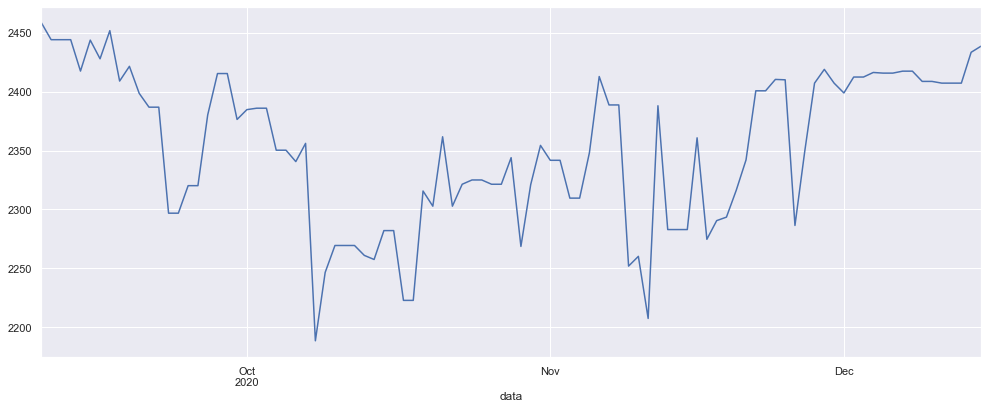

In [17]:
y.plot(figsize=(15,6))
plt.show()

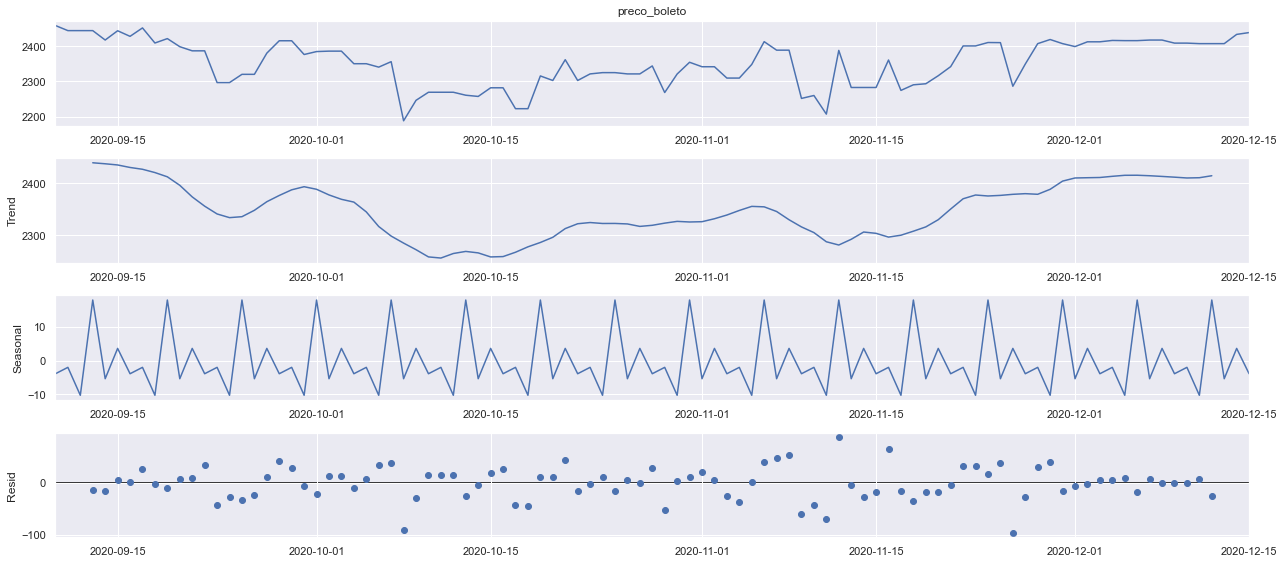

In [18]:
import matplotlib as mpl
rcp = mpl.rcParams
rcp['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive', period=6)
fig = decomposition.plot()
plt.show()

In [19]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [20]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1765.0085035488528
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:981.5564068762318
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:831.697519935962
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:994.8367285881644
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:970.043640223912
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:847.1746417339926
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:824.9913780058866
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1623.9077547271297
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1326.5248772056873
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:940.1551287053744
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:790.7589303122323
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:966.7859679601293
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:951.3210398308727
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:821.9715552512839
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:787.7023978485388
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:998.1787311720414
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:879.1711557322913
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:927.2228453225698
ARIMA(0, 

In [21]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4330      0.257      1.688      0.091      -0.070       0.936
ma.L1         -0.7709      0.194     -3.975      0.000      -1.151      -0.391
ma.S.L12      -0.9998    185.477     -0.005      0.996    -364.527     362.528
sigma2      1855.5346   3.44e+05      0.005      0.996   -6.72e+05    6.76e+05


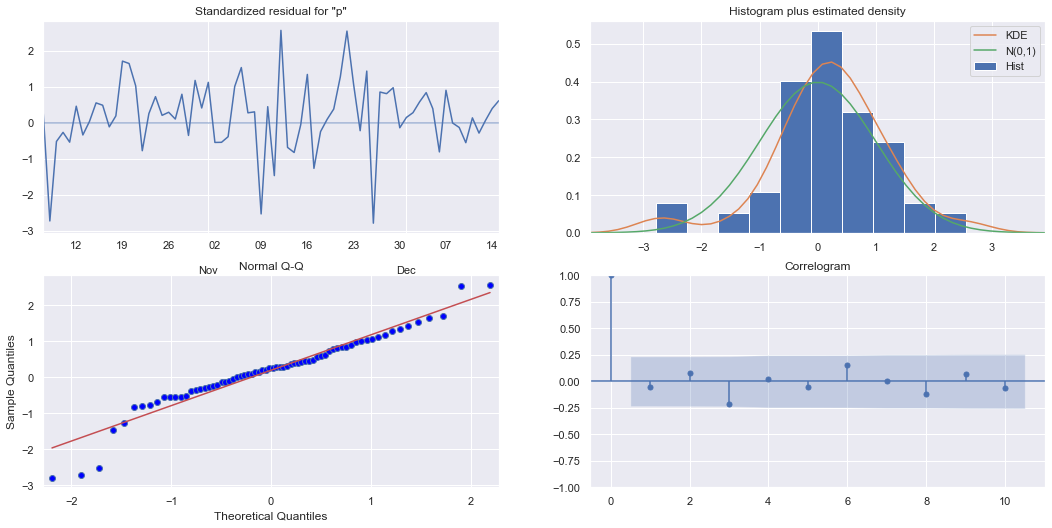

In [22]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

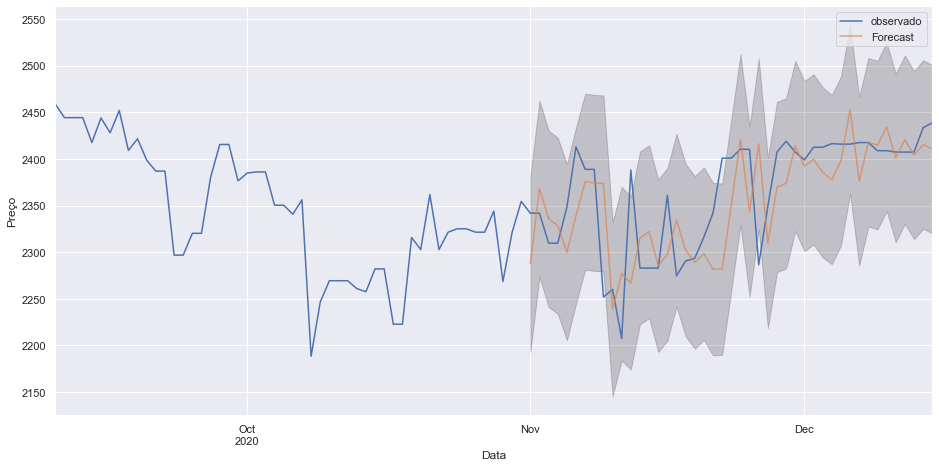

In [23]:
pred = results.get_prediction(start=pd.to_datetime('2020-11-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2020':].plot(label='observado')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Data')
ax.set_ylabel('Preço')
plt.legend()
plt.show()

In [24]:
y_forecasted = pred.predicted_mean
y_truth = y['2020-09-10':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2507.3


In [25]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 50.07


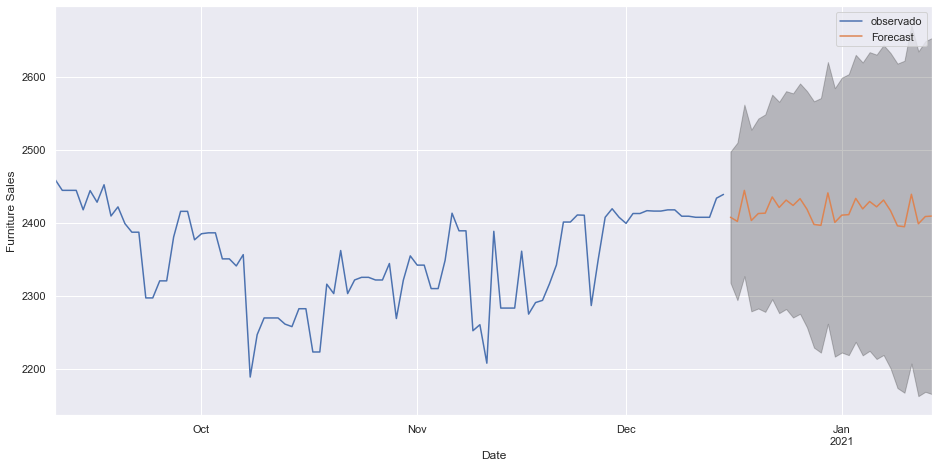

In [26]:
pred_uc = results.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observado', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales') u
plt.legend()
plt.show()